In [4]:
# Necessary Imports
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from pymongo import MongoClient
from dotenv import load_dotenv
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from scipy.fft import fft
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import seaborn as sns
from generation import generate_gaze_points

# Load environment variables
load_dotenv()


True

In [7]:
key_width = 160 * 0.75

def generate_key_positions(win_width=2048, win_height=1152, key_width=160 * 0.75, key_height=160 * 0.75, horizontal_spacing=key_width * 0.25, vertical_spacing=200, num_points=100):
    top_row_y = win_height / 2 - vertical_spacing * 1.5
    middle_row_y = top_row_y - vertical_spacing
    bottom_row_y = middle_row_y - vertical_spacing

    row1_labels = ['Q', 'W', 'E', 'R', 'T', 'Y', 'U', 'I', 'O', 'P']
    row2_labels = ['A', 'S', 'D', 'F', 'G', 'H', 'J', 'K', 'L']
    row3_labels = ['Z', 'X', 'C', 'V', 'B', 'N', 'M']

    def calculate_start_x(num_keys):
        total_width = num_keys * key_width + (num_keys - 1) * horizontal_spacing
        return -total_width / 2 + key_width / 2

    def compute_key_positions(labels, start_x, y_pos):
        positions = []
        for i, label in enumerate(labels):
            x = start_x + i * (key_width + horizontal_spacing)
            positions.append((label, [x, y_pos]))
        return positions

    start_x_row1 = calculate_start_x(len(row1_labels))
    start_x_row2 = calculate_start_x(len(row2_labels))
    start_x_row3 = calculate_start_x(len(row3_labels))

    key_positions = {}
    for label, pos in compute_key_positions(row1_labels, start_x_row1, top_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row2_labels, start_x_row2, middle_row_y):
        key_positions[label.upper()] = pos
    for label, pos in compute_key_positions(row3_labels, start_x_row3, bottom_row_y):
        key_positions[label.upper()] = pos

    key_positions['BOTAO_ACABAR'] = [0, bottom_row_y - vertical_spacing]

    return key_positions

positions = generate_key_positions()

In [54]:
from sklearn.model_selection import train_test_split

with open('words.txt', 'r') as f:
    words_list = f.readlines()
words_list = [word.strip() for word in words_list]
words_list = words_list

num_synthetic_samples_per_word = 250
num_points = 170
key_positions = positions  

import os
from pymongo import MongoClient
from comp_metric import get_last_n_gestures
client = MongoClient(os.getenv('MONGO_URI'))
db = client["wgaze"]
collection = db['batches']

# Fetch last 100 gestures
N = 200
last_300_gestures = get_last_n_gestures(db, 'batches', N)
real_gesture_words = []
real_gesture_data = []
for gesture in last_300_gestures:
    if gesture['word'] in words_list:
        real_gesture_words.append(gesture['word'])
        real_gesture_data.append(gesture['data'])
    else:
        continue 

len(real_gesture_words)

200

Extracting features...
Training the classifier...
Epoch [1/20], Training Loss: 2.1752, Validation Loss: 3.5879
Epoch [2/20], Training Loss: 0.9029, Validation Loss: 3.3931
Epoch [3/20], Training Loss: 0.6753, Validation Loss: 2.8983
Epoch [4/20], Training Loss: 0.5467, Validation Loss: 3.1834
Epoch [5/20], Training Loss: 0.4741, Validation Loss: 2.9298
Epoch [6/20], Training Loss: 0.4185, Validation Loss: 2.7301
Epoch [7/20], Training Loss: 0.3841, Validation Loss: 2.9293
Epoch [8/20], Training Loss: 0.3492, Validation Loss: 2.9814
Epoch [9/20], Training Loss: 0.3249, Validation Loss: 2.5011
Epoch [10/20], Training Loss: 0.3048, Validation Loss: 2.7449
Epoch [11/20], Training Loss: 0.2870, Validation Loss: 2.7003
Epoch [12/20], Training Loss: 0.2740, Validation Loss: 2.4685
Epoch [13/20], Training Loss: 0.2562, Validation Loss: 2.5301
Epoch [14/20], Training Loss: 0.2548, Validation Loss: 2.4371
Epoch [15/20], Training Loss: 0.2329, Validation Loss: 2.6272
Epoch [16/20], Training Loss:

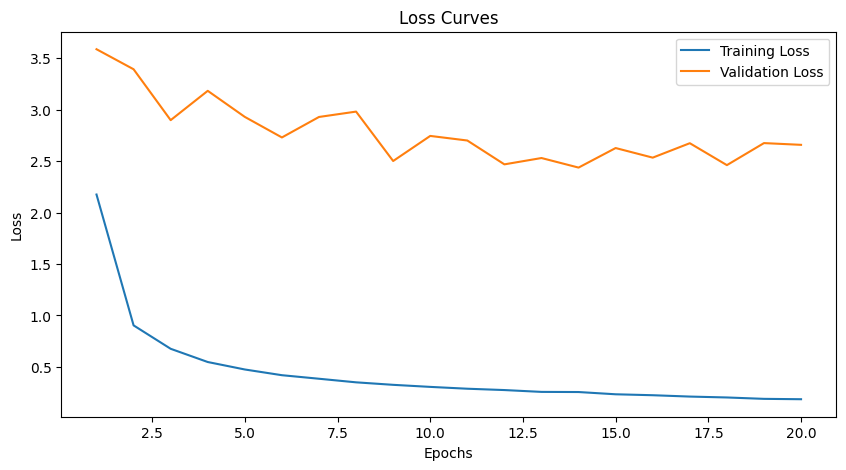

In [85]:
from sklearn.preprocessing import MinMaxScaler

synthetic_data =[]
synthetic_labels = []
for word in real_gesture_words:
    for _ in range(num_synthetic_samples_per_word):
        gaze_points = generate_gaze_points(word, key_positions, num_points)
        gaze_points = np.array(gaze_points)
        synthetic_data.append(gaze_points)
        synthetic_labels.append(word)

def pad_or_truncate(gaze_points, num_points):
    if gaze_points.shape[0] > num_points:
        return gaze_points[:num_points]
    else:
        num_points_to_add = num_points - gaze_points.shape[0]
        return np.concatenate((gaze_points, np.zeros((num_points_to_add, 2))))

real_gestures_processed = []
for data in real_gesture_data:
    gaze = np.array(data)
    gaze = pad_or_truncate(gaze, num_points)
    real_gestures_processed.append(gaze)

real_gestures_processed = np.array(real_gestures_processed)
synthetic_data = np.array(synthetic_data)
def normalize_data(data, min_val, max_val):
    return 2 * (data - min_val) / (max_val - min_val) - 1

all_key_positions_x = [pos[0] for pos in positions.values()]
all_key_positions_y = [pos[1] for pos in positions.values()]

min_x, max_x = min(all_key_positions_x), max(all_key_positions_x)
min_y, max_y = min(all_key_positions_y), max(all_key_positions_y)

synthetic_data = normalize_data(synthetic_data, min_x, max_x)
real_gestures_processed = normalize_data(real_gestures_processed, min_x, max_x)


def extract_features(gaze_points):
    x = gaze_points[:, 0]
    y = gaze_points[:, 1]


    features = np.concatenate((x, y))
    return features

print("Extracting features...")
synthetic_features = []
for gaze_points in synthetic_data:
    features = extract_features(gaze_points)
    synthetic_features.append(features)

real_features = []
for gaze_points in real_gestures_processed:
    features = extract_features(gaze_points)
    real_features.append(features)



label_encoder = LabelEncoder()
synthetic_labels_encoded = label_encoder.fit_transform(synthetic_labels)
real_labels_encoded = label_encoder.transform(real_gesture_words)

X_train, X_eval, y_train, y_eval = train_test_split(synthetic_features, synthetic_labels_encoded, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_eval = torch.tensor(real_features, dtype=torch.float32)
y_eval = torch.tensor(real_labels_encoded, dtype=torch.long)



class GazeDataset(Dataset):
    def __init__(self, features, labels):
        self.X = features
        self.y = labels
    def __len__(self):
        return len(self.y)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]



train_dataset = GazeDataset(X_train, y_train)
test_dataset = GazeDataset(X_eval, y_eval)


#cropei o subset de metade dos dados reais pra combinar pra usar no treino, e os outros 100 pra testar dps
test_to_combine = torch.utils.data.Subset(test_dataset, range(0, 100))
combined_dataset = torch.utils.data.ConcatDataset([train_dataset, test_to_combine])

combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#continuo usando como validacao aq so os dados reais
eval_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



class ConvClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConvClassifier, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.relu3 = nn.ReLU()
        
        self.fc1 = nn.Linear(128 * input_size, 256)
        self.relu4 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.relu5 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(128, num_classes)
        
    def forward(self, x):
        B, L = x.shape  
        x = x.view(x.size(0), 1, -1)  # adiciona a dimensão de canal
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        
        x = x.view(B, -1) 
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        
        return x


input_size = X_train.shape[1]
num_classes = len(label_encoder.classes_)
model = ConvClassifier(input_size, num_classes).to('cuda')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
training_loss = []
validation_loss = []

print("Training the classifier...")
for epoch in range(num_epochs):
    model.train()
    epoch_training_loss = 0
    for batch_X, batch_y in combined_loader:
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_training_loss += loss.item()
    avg_training_loss = epoch_training_loss / len(combined_loader)
    training_loss.append(avg_training_loss)

    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in eval_loader:
            batch_X = batch_X.to('cuda')
            batch_y = batch_y.to('cuda')
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            epoch_val_loss += loss.item()
    avg_val_loss = epoch_val_loss / len(eval_loader)
    validation_loss.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_training_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), training_loss, label='Training Loss')
plt.plot(range(1, num_epochs+1), validation_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()

In [86]:
print(len(label_encoder.classes_))

200


tensor([ 76, 167,  77,  39,  74, 105, 172,  51,  47, 163, 145, 156,  75, 117,
        165,  81,  70, 116,  43,  44, 125, 106,  86, 108,  94, 132,  33,  71,
         88,  35,  93, 148])
tensor([178, 160,  83,  18,  30, 142, 179, 158,  62, 198, 168, 183,  61, 134,
        109, 154,  59, 110,  11, 150, 181, 124, 122, 107, 186,  52, 199, 189,
        118, 149,  92, 119])
tensor([185,  84,   7,  87, 102,  63, 192,  21, 187,  13,  46,  15,   6, 171,
         12, 146, 138, 101,  80, 176,  99, 196,  34, 121,  64,  25,  60,   9,
        136,  37, 153,  36])
tensor([135, 143, 112, 113])
Validation Accuracy: 0.9000
Training Accuracy: 0.9995
(105, 105)


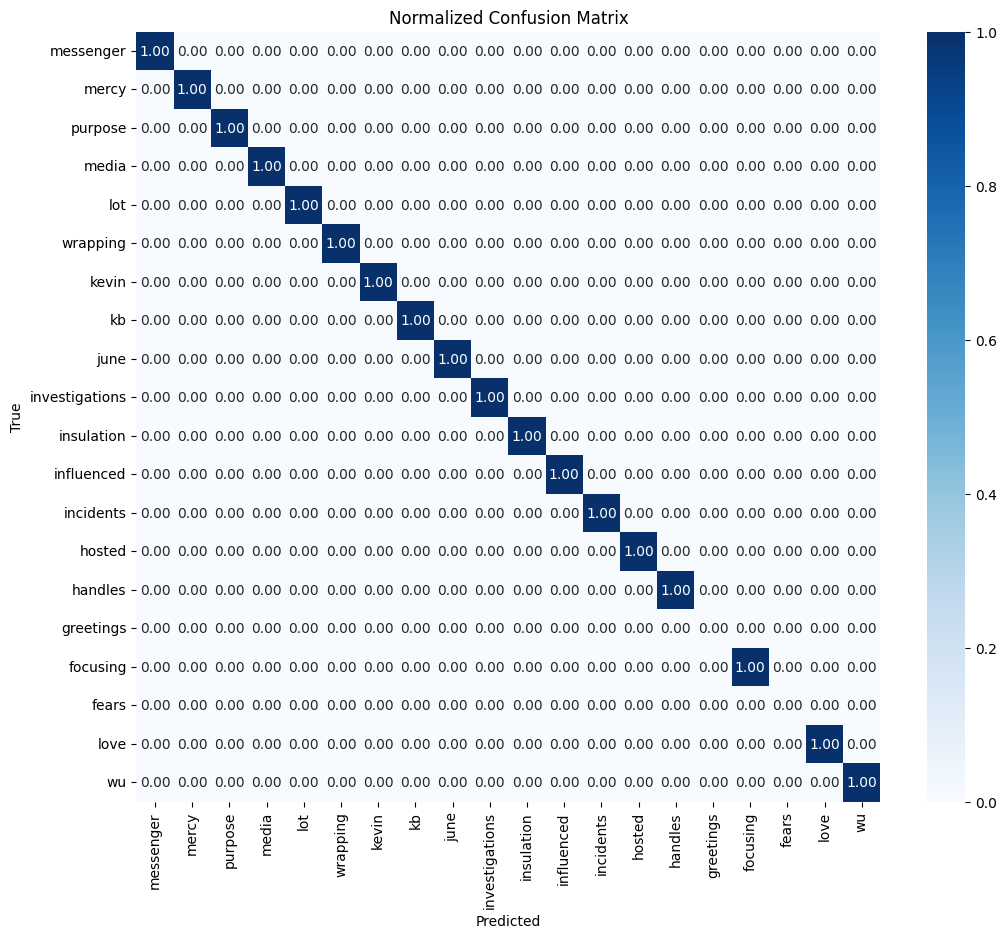

In [87]:

model.eval()
y_true = []
y_pred = []
y_true_train = []
y_pred_train = []

eval_subset = torch.utils.data.Subset(test_dataset, range(100,))
eval_subset_loader = DataLoader(eval_subset, batch_size=32, shuffle=False)

with torch.no_grad():
    for batch_X, batch_y in eval_subset_loader:
        print(batch_y)
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(batch_y.tolist())
        y_pred.extend(predicted.tolist())

with torch.no_grad():
    for batch_X, batch_y in combined_loader:
        batch_X = batch_X.to('cuda')
        batch_y = batch_y.to('cuda')
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        y_true_train.extend(batch_y.tolist())
        y_pred_train.extend(predicted.tolist())


accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
accuracy_train = accuracy_score(y_true_train, y_pred_train)
print(f"Training Accuracy: {accuracy_train:.4f}")



cm = confusion_matrix(y_true, y_pred)
print(cm.shape)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)
cm_top_n = confusion_matrix(y_true, y_pred, labels=top_n_classes_idx)
plot_confusion_matrix(cm_top_n, top_n_classes)

In [66]:
#print number of parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {num_params}")

Number of parameters: 11231112


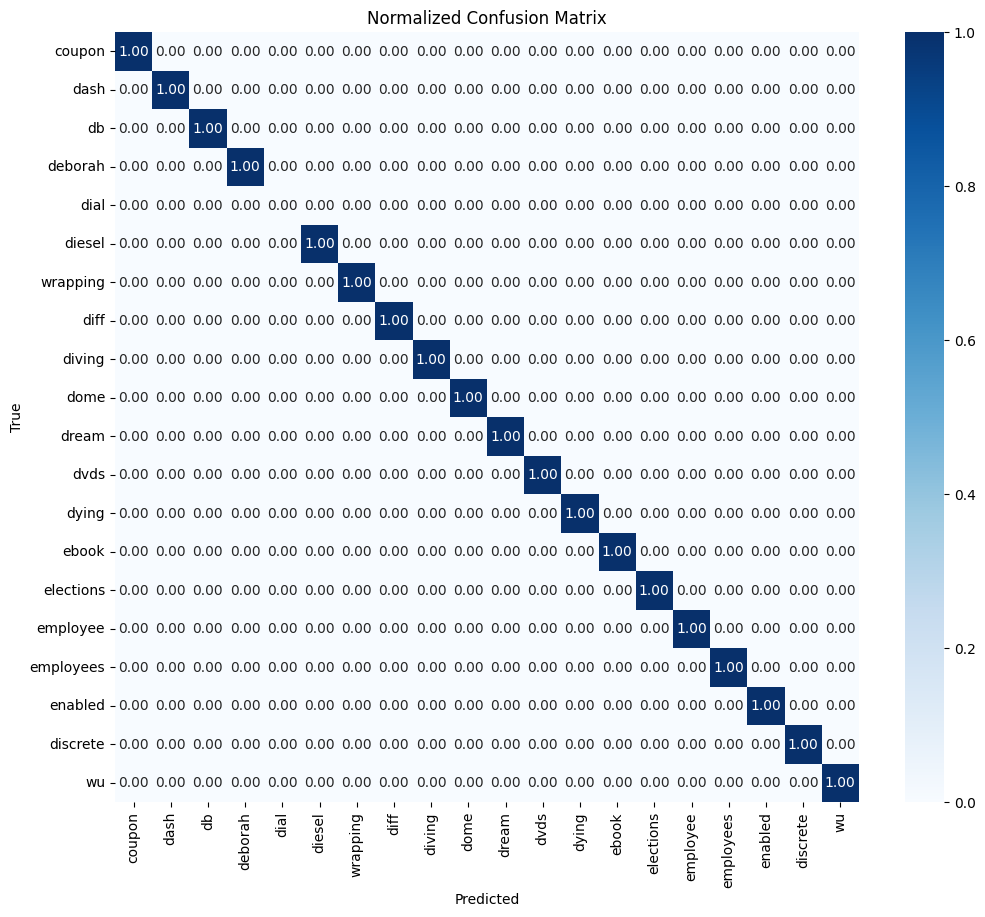

In [67]:
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Normalized Confusion Matrix')
    plt.show()


top_n = 20  
class_counts = np.bincount(y_true)
top_n_classes_idx = np.argsort(class_counts)[-top_n:]
top_n_classes = label_encoder.inverse_transform(top_n_classes_idx)

cm_top_n = cm[np.ix_(top_n_classes_idx, top_n_classes_idx)]

plot_confusion_matrix(cm_top_n, top_n_classes)

350